In [1]:
# coding=utf-8
import sys,os
import asyncio
import aiohttp
import json
from datetime import datetime
import pandas as pd
import time
import csv
import codecs
import math
import csv
import random
import string
import numpy as np
import quantstats as qs



In [2]:
def mean(data):
    n = len(data)
    _mean = sum(data) / n    
    return _mean

def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

In [3]:
# 布林帶標準算式
def calc_entry_price_boll(klines,cnt,boll_cnt,boll_std):
    closearr = []
    for k in range(len(klines)):
        if(k%cnt == 0):
            closearr.append(float(klines[-k-1][1]))
        if(len(closearr)>=boll_cnt):
            break
    mean = sum(closearr) / len(closearr)
    std = stdev(closearr)
    upper = mean + std * boll_std
    lower = mean - std * boll_std
    return upper,lower


In [4]:
def calcLiquidity(
    cprice,
    upper,
    lower,
    amountX,
    amountY
):
    liquidity = 0
    if(cprice <= lower):
        liquidity = amountX * (math.sqrt(upper) * math.sqrt(lower)) / (math.sqrt(upper) - math.sqrt(lower))
    elif(upper < cprice):
        Lx = amountX * (math.sqrt(upper) * math.sqrt(cprice)) / (math.sqrt(upper) - math.sqrt(cprice))
        Ly = amountY / (math.sqrt(cprice) - math.sqrt(lower))
        liquidity = min(Lx,Ly)
    else:
        liquidity = amountY / (math.sqrt(upper) - math.sqrt(lower))
    
    return liquidity


In [5]:
def calc_price_ranking(klines):
    
    curprice = float(klines[-1][1])
    C5 = curprice
    cnt_day = int(24)
    cnt_4hr = int(4)
    cnt_1hr = 1
    #cnt_15m = 15
    upper_day,lower_day = calc_entry_price_boll(klines,cnt_day,boll_cnt,boll_std)
    upper_4hr,lower_4hr = calc_entry_price_boll(klines,cnt_4hr,boll_cnt,boll_std)
    upper_1hr,lower_1hr = calc_entry_price_boll(klines,cnt_1hr,boll_cnt,boll_std)
    #upper_15m,lower_15m = calc_entry_price_boll(klines,cnt_15m,boll_cnt,boll_std)
    
    E5 = upper_day
    C30 = E5
    C32 = upper_4hr
    C34 = upper_1hr
    C36 = upper_1hr
    D31 = (C30+C32)/2
    D33 = (C32+C34)/2
    D35 = (C34+C36)/2
    E32 = (D31+D33)/2
    E34 = (D33+D35)/2
    F33 = (E32+E34)/2
    
    
    H5 = lower_day
    H17 = upper_1hr
    
    C39 = H5
    C41 = lower_4hr
    C43 = lower_1hr
    C45 = lower_1hr
    D40 = (C39+C41)/2
    D42 = (C41+C43)/2
    D44 = (C43+C45)/2
    E41 = (D40+D42)/2
    E43 = (D42+D44)/2
    F42 = (E41+E43)/2
    
    # 短頂
    E23 = (F33+C5)/2*C24
    # 短底
    E27 = (F42+C5)/2*C26
    # 中
    E25 = (E23+E27)/2
    # (中＋頂) / 2
    E24 = (E23+E25)/2
    # (中＋底) / 2
    E26 = (E25+E27)/2
    
    return {'HH':E23,'HM':E24,'MM':E25,'ML':E26,'LL':E27,
            'BDU':upper_day,'BDL':lower_day,
            'B4U':upper_4hr,'B4L':lower_4hr,
            'B1U':upper_1hr,'B1L':lower_1hr,
            #'B15U':upper_15m,'B15L':lower_15m,
            }

In [6]:
def getTokenAmountsFromDepositAmounts(
    P,  # 初始建倉位置
    Pl, # 下界 Pl = lower
    Pu, # 上界 Pu = upper
    priceUSDX, # 幣種1對美元 priceUSDX = cprice_eth
    priceUSDY, # 幣種2對美元 priceUSDY = 1
    targetAmounts # 投入資金美金計價 targetAmounts = initCapital
):
    deltaL = targetAmounts / ((math.sqrt(P) - math.sqrt(Pl)) * priceUSDY + 
                            (priceUSDX / math.sqrt(P) - priceUSDX / math.sqrt(Pu)) )

    deltaY = deltaL * (math.sqrt(P) - math.sqrt(Pl))
    if (deltaY * priceUSDY < 0):
        deltaY = 0
    if (deltaY * priceUSDY > targetAmounts): 
        deltaY = targetAmounts / priceUSDY

    deltaX = deltaL * (1 / math.sqrt(P) - 1 / math.sqrt(Pu))
    if (deltaX * priceUSDX < 0):
        deltaX = 0;
    if (deltaX * priceUSDX > targetAmounts):
        deltaX = targetAmounts / priceUSDX

    return deltaX,deltaY


In [7]:
def getILPriceChange(
    price, # 初始建倉位置
    newPrice, # 當前幣價 P=cprice_eth
    upper,  # 上界 Pu = upper
    lower, # 下界 Pl = lower
    amountX, # 初始eth數量
    amountY # 初始u數量
):
    L = calcLiquidity(price,upper,lower,amountX,amountY)
    deltaP = math.sqrt(newPrice) - math.sqrt(price)
    oneOverDeltaP = 1/(math.sqrt(newPrice)) - 1/(math.sqrt(price))
    deltaX = oneOverDeltaP * L
    deltaY = deltaP * L
    Lx2 = max(amountX + deltaX,0)
    Ly2 = max(amountY + deltaY,0)
    #newAssetValue = Lx2 * newPrice + Ly2
    
    return Lx2,Ly2


In [8]:
# ##############################
#       交易參數設置
# ##############################

boll_cnt = 20 
boll_std = 2
C24 = 1.01
C25 = 1
C26 = 0.95

# 初始資金
initCapital = 100000

# 做多資金 & 多方部位紀錄
equity_long = initCapital * 0.5
entry_price_upper_long = 0
entry_price_lower_long = 0
entry_price_long = 0
entry_amt0_long = 0
entry_amt1_long = 0
deltaX_long=0
deltaY_long=0

# 做空資金 & 空方部位紀錄
equity_short = initCapital * 0.5
entry_price_upper_short = 0
entry_price_lower_short = 0
entry_price_short = 0
entry_amt0_short = 0
entry_amt1_short = 0
hedgeRatio = 0.9 # 做空比率
miningRatio = 0.9 # 拿來做 uniswap LP 比率，增加部位中性程度
longAmt=0 #借幣後殘存的幣
shortAmt=0
deltaX_short=0
deltaY_short=0

# 交易紀錄
entry_time = 0
punish_cnt = 0
# records
priceRank = {}
start_hour = 22 # record 專用
skip_num = 24*365 # 跳過前一年

# 標的
ins = "MATIC"

In [9]:
# 讀取 1h k bar

all_klines = []
infile = os.getcwd()+'/data/'+ins+'_1h.csv'
with open(infile) as file_name:
    file_read = csv.reader(file_name)
    all_klines = list(file_read)
all_klines.pop(0)
print(all_klines[0])

['2019-04-26 15:00:00', '0.00990000', '0.01052000', '0.00526000', '0.00630000', '1429346565.00000000']


In [10]:
# Quantstats 每日統計用 dataframe

dateparse = lambda x:pd.to_datetime(x).date()  # datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(infile, parse_dates=['Open time'], date_parser=dateparse, encoding='utf-8')
dft = df.drop_duplicates(subset=['Open time'],keep='last')
dt_ret = dft.filter(['Open time','Close'], axis=1)
#dt_ret['return'] = dt_ret['Close'].astype(float).pct_change(1)
dt_ret.set_index(pd.DatetimeIndex(dt_ret['Open time']),inplace=True)
qsdf = dt_ret[['Open time','Close']].copy()
qsdf = qsdf.iloc[int(skip_num/24):]
qsdf['Close'] = initCapital
print(qsdf.head(5))

            Open time   Close
Open time                    
2020-04-25 2020-04-25  100000
2020-04-26 2020-04-26  100000
2020-04-27 2020-04-27  100000
2020-04-28 2020-04-28  100000
2020-04-29 2020-04-29  100000


In [11]:
# 繪圖用 dataframe

dateparser = lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dfh = pd.read_csv(infile, parse_dates=['Open time'], date_parser=dateparser, encoding='utf-8')
dfh['long_entry'] = 0
dfh['long_exit'] = 0
dfh['short_entry'] = 0
dfh['short_exit'] = 0
dfh = dfh.iloc[int(skip_num):]
print(dfh.head(5))

               Open time     Open     High      Low    Close      Volume  \
8760 2020-04-27 06:00:00  0.01528  0.01530  0.01480  0.01509  42110118.8   
8761 2020-04-27 07:00:00  0.01508  0.01529  0.01497  0.01529  13891597.7   
8762 2020-04-27 08:00:00  0.01529  0.01536  0.01501  0.01512  17553601.8   
8763 2020-04-27 09:00:00  0.01512  0.01521  0.01499  0.01517  10528603.8   
8764 2020-04-27 10:00:00  0.01515  0.01517  0.01499  0.01506  12841619.8   

      long_entry  long_exit  short_entry  short_exit  
8760           0          0            0           0  
8761           0          0            0           0  
8762           0          0            0           0  
8763           0          0            0           0  
8764           0          0            0           0  


In [12]:
# backtest mainloop

for k in range(skip_num,len(all_klines)-1):
    kl = all_klines[k]
    curhour = int(kl[0].split(' ')[1].split(':')[0])
    numbar = min(boll_cnt*24,k)
    if(curhour == start_hour): # collect record
        P = float(kl[4])
        if(entry_price_lower_long>0):
            P_clamp = min(max(P,entry_price_lower_long),entry_price_upper_long)
            amt1,amt2 = getILPriceChange(entry_price_long,P_clamp,entry_price_upper_long,entry_price_lower_long,deltaX_long,deltaY_long)
            equity_long = amt1 * P + amt2
        elif(entry_price_lower_short>0):
            P_clamp = min(max(P,entry_price_lower_short),entry_price_upper_short)
            amt1,amt2 = getILPriceChange(entry_price_short,P_clamp,entry_price_upper_short,entry_price_lower_short,deltaX_short,deltaY_short)
            curamt = amt1+amt2/P + longAmt
            equity_short = equity_short - (shortAmt - curamt)*P

        priceRank = calc_price_ranking(all_klines[k-numbar:k+1])
        #print('new price rank setup ' + str(priceRank['LL']))
        net_value = equity_long + equity_short
        _dt = datetime.strptime(kl[0].split(' ')[0],'%Y-%m-%d')
        qsdf.at[_dt, 'Close'] = net_value
        

    if(priceRank != {}):

        if(entry_price_lower_short<0.001):
            #print('price test '+str(float(kl[3])) + ' ' + str(priceRank['ML']))
            # short entry
            if(float(kl[2])>=priceRank['HH']):
                hedgeamt = equity_short*0.7
                short_coin_amt = hedgeamt / float(kl[2])
                liquidation_price = equity_short / short_coin_amt 
                entry_price_upper_short = liquidation_price*0.9
                entry_price_lower_short = priceRank['LL']

                # 
                entry_price_short = priceRank['HH']
                # 一開始借幣數量
                hedgeUSDAmt = equity_short * hedgeRatio
                # 借來的顆數
                shortAmt = hedgeUSDAmt/entry_price_short
                # 借來的顆數實際拿下去作市的數量
                miningAmt = shortAmt*miningRatio
                # 借來的，持幣不參與作市
                longAmt = shortAmt - miningAmt 
                mining_usd_amt = hedgeUSDAmt
                deltaX_short,deltaY_short = getTokenAmountsFromDepositAmounts(entry_price_short, entry_price_lower_short, entry_price_upper_short, entry_price_short, 1, mining_usd_amt)

                entry_time = k
                #print('------- new short entry :' + kl[2] +' sl:'+ str(entry_price_upper_short)  +' fund:'+ str(equity_short) + ' entry time ' + str(kl[0]))
                dfh.at[k,'short_entry'] = 1
        
        # long entry
        #print('price test '+str(float(kl[3])) + ' ' + str(priceRank['ML']))
        if(entry_price_lower_long<0.001):
            if(float(kl[3])<=priceRank['LL']):
                entry_price_upper_long = priceRank['HH']
                entry_price_lower_long = priceRank['LL'] * 0.2
                entry_price_long = priceRank['LL']
                entry_time = k
                deltaX_long,deltaY_long = getTokenAmountsFromDepositAmounts(entry_price_long, entry_price_lower_long, entry_price_upper_long, entry_price_long, 1, equity_long)

                #print('+++++++ new long entry price '+ kl[2] + ' sl:'+ str(entry_price_lower_long)  +' fund:'+ str(equity_long) + ' entry time ' + str(kl[0]))
                dfh.at[k,'long_entry'] = 1

        if(k>entry_time):
            # short win 
            if(entry_price_lower_short>0):
                if(float(kl[3])<=entry_price_lower_short):

                    P = entry_price_lower_short
                    # 當前經過 IL 計算之後部位剩餘顆數
                    P_clamp = min(max(P,entry_price_lower_short),entry_price_upper_short)
                    amt1,amt2 = getILPriceChange(entry_price_short,P_clamp,entry_price_upper_short,entry_price_lower_short,deltaX_short,deltaY_short)
                    curamt = amt1+amt2/P + longAmt
                    equity_short = equity_short - (shortAmt - curamt)*P
                    #print(  '￥ short win , hit price lower ' + str(entry_price_lower_short) + ' lower price:'+str(kl[3]) +' fund:'+ str(equity_short) +' exit time' +str(kl[0]) )

                    entry_price_upper_short = 99999999
                    entry_price_lower_short = 0

                    dfh.at[k,'short_exit'] = 1
                # short lost
                if(float(kl[2])>=entry_price_upper_short):
                    P = entry_price_upper_short
                    # 當前經過 IL 計算之後部位剩餘顆數
                    P_clamp = min(max(P,entry_price_lower_short),entry_price_upper_short)
                    amt1,amt2 = getILPriceChange(entry_price_short,P_clamp,entry_price_upper_short,entry_price_lower_short,deltaX_short,deltaY_short)
                    curamt = amt1+amt2/P + longAmt
                    equity_short = equity_short - (shortAmt - curamt)*P
                    #print( 'xxx            short lost , hit stoploss ' + str(entry_price_upper_short) + ' curr price:'+ str(kl[2])  +' fund:'+ str(equity_short) + '@' +str(kl[0]) )
                    punish_cnt+=1
                    entry_price_upper_short = 99999999
                    entry_price_lower_short = 0

                    dfh.at[k,'short_exit'] = 1

            # long win
            if(entry_price_lower_long>0):
                if(float(kl[2])>=entry_price_upper_long):
                    P = entry_price_upper_long
                    # 當前經過 IL 計算之後部位剩餘顆數
                    P_clamp = min(max(P,entry_price_lower_long),entry_price_upper_long)
                    amt1,amt2 = getILPriceChange(entry_price_long,P_clamp,entry_price_upper_long,entry_price_lower_long,deltaX_long,deltaY_long)
                    equity_long = amt1 * P + amt2
                    #print( ' ￥ long win , hit price upper ' + str(entry_price_upper_long) + ' curr high:'+str(kl[2]) +' fund:'+ str(equity_long) + ' exit time' +str(kl[0]) ) 

                    entry_price_upper_long = 0
                    entry_price_lower_long = 0

                    dfh.at[k,'long_exit'] = 1

            # long lost
            if(float(kl[3])<=entry_price_lower_long):
                P = entry_price_lower_long
                # 當前經過 IL 計算之後部位剩餘顆數
                P_clamp = min(max(P,entry_price_lower_long),entry_price_upper_long)
                amt1,amt2 = getILPriceChange(entry_price_long,P_clamp,entry_price_upper_long,entry_price_lower_long,deltaX_long,deltaY_long)
                equity_long = amt1 * P + amt2
                #print( 'xxx         long lost , hit stoploss ' + str(entry_price_lower_long) + ' curr low:'+str(kl[3]) +' fund:'+ str(initCapital) +  '@' +str(kl[0]) )

                punish_cnt+=1
                entry_price_upper_long = 0
                entry_price_lower_long = 0

                dfh.at[k,'long_exit'] = 1
                    

# 資產淨值，填入最後一筆
fin_dt = datetime.strptime(all_klines[-1][0].split(' ')[0],'%Y-%m-%d')
qsdf.at[fin_dt, 'Close'] = equity_long + equity_short


In [13]:
qsdf.tail(10)

,Open time,Close
Open time,,
2022-12-09,2022-12-09,195722192
2022-12-10,2022-12-10,195722186
2022-12-11,2022-12-11,195722047
2022-12-12,2022-12-12,195722193
2022-12-13,2022-12-13,195722253
2022-12-14,2022-12-14,195722151
2022-12-15,2022-12-15,195721898
2022-12-16,2022-12-16,195721147
2022-12-17,2022-12-17,195721279


In [14]:
# 小時線進出場訊號
dfh

,Open time,Open,High,Low,Close,Volume,long_entry,long_exit,short_entry,short_exit
8760,2020-04-27 06:00:00,0.01528,0.01530,0.01480,0.01509,42110118.8,0,0,0,0
8761,2020-04-27 07:00:00,0.01508,0.01529,0.01497,0.01529,13891597.7,0,0,0,0
8762,2020-04-27 08:00:00,0.01529,0.01536,0.01501,0.01512,17553601.8,0,0,0,0
8763,2020-04-27 09:00:00,0.01512,0.01521,0.01499,0.01517,10528603.8,0,0,0,0
8764,2020-04-27 10:00:00,0.01515,0.01517,0.01499,0.01506,12841619.8,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
31872,2022-12-18 02:00:00,0.81190,0.81610,0.81130,0.81610,887641.2,0,0,0,0
31873,2022-12-18 03:00:00,0.81610,0.81850,0.81430,0.81830,881914.0,0,0,0,0
31874,2022-12-18 04:00:00,0.81820,0.82640,0.81820,0.82230,2763932.1,0,0,0,0
31875,2022-12-18 05:00:00,0.82240,0.82300,0.81680,0.81710,897609.6,0,0,0,0


Last year long entry signals


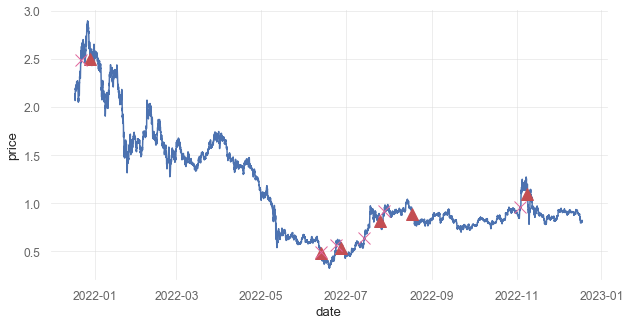

In [19]:

# signal plot
import matplotlib.pyplot as plt

# take last short period
#a,b=list(dfh[dfh['short_entry']!=0].iloc[:2].index)
#newbie=dfh[a-158:b+130]
newbie=dfh[-24*365:]
newbie.set_index(newbie['Open time'],inplace=True)

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

# Plot the data in the first subplot
ax.plot(newbie['Close'],label='price')
ax.plot(newbie['Close'][newbie['long_entry']==1],marker='^',markersize=12,lw=0,c='r',label='LONG_ENTRY')
ax.plot(newbie['Close'][newbie['long_exit']==1],marker='x',markersize=12,lw=0,c='#e1679c',label='SHORT_EXIT')

ax.set_xlabel('date')
ax.set_ylabel('price')

print('Last year long entry signals')

Text(0, 0.5, 'price')

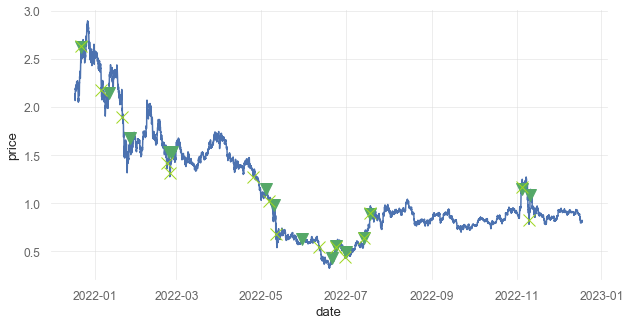

In [18]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

# Plot the data in the first subplot
ax.plot(newbie['Close'],label='price')
ax.plot(newbie['Close'][newbie['short_entry']==1],marker='v',markersize=12,lw=0,c='g',label='SHORT_ENTRY')
ax.plot(newbie['Close'][newbie['short_exit']==1],marker='x',markersize=12,lw=0,c='#9fd71f',label='LONG_EXIT')

ax.set_xlabel('date')
ax.set_ylabel('price')

Whole period equity


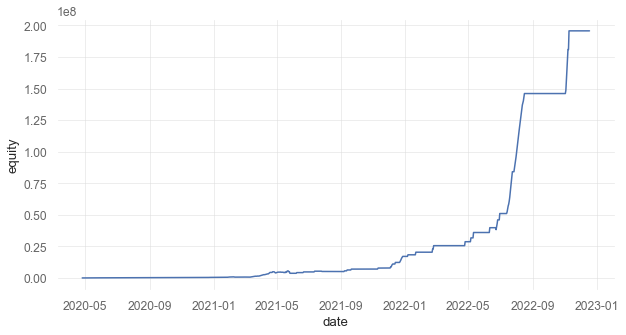

In [20]:

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

# Plot the data in the first subplot
ax.plot(qsdf['Close'],label='equity')

ax.set_xlabel('date')
ax.set_ylabel('equity')

print('Whole period equity')

In [21]:
# quantstats reports

qsdf['return'] = qsdf['Close'].astype(float).pct_change(1)
mqt = qsdf[['return']].copy()
matx = qs.reports.metrics(mqt,mode='full',display=True,prepare_returns=False)
print('backtest final capital '+str( equity_long + equity_short ) + ' stoploss count '+str(punish_cnt))


                           Strategy
-------------------------  -----------
Start Period               2020-04-25
End Period                 2022-12-18
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          195,621.28%
CAGR﹪                     1647.63%

Sharpe                     4.59
Prob. Sharpe Ratio         100.0%
Smart Sharpe               3.71
Sortino                    10.61
Smart Sortino              8.57
Sortino/√2                 7.5
Smart Sortino/√2           6.06
Omega                      5.99

Max Drawdown               -32.73%
Longest DD Days            108
Volatility (ann.)          45.31%
Calmar                     50.35
Skew                       1.03
Kurtosis                   12.21

Expected Daily %           0.79%
Expected Monthly %         25.82%
Expected Yearly %          1150.87%
Kelly Criterion            49.34%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.87%
Expected Shortfall (cVaR)  -3.87%

Max Consecu